In [23]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.cluster.hierarchy import linkage, fcluster
from collections import defaultdict
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


Para realizar análises de cointegração e construir estratégias de arbitragem estatística, é necessário dispor de **séries temporais de preços históricas**. Este bloco descarrega os preços de **fecho diário** de uma lista de ações tecnológicas e financeiras cotadas na bolsa dos EUA.

Alguns detalhes importantes:

- A lista de **tickers** contém empresas relevantes nos setores de tecnologia, semicondutores, software, segurança cibernética, e-commerce, entre outros;
- O intervalo de dados vai de **2018-01-01 até 2025-01-01**, permitindo uma análise robusta de longo prazo;
- A instrução `dropna(axis=1, thresh=...)` remove colunas com muitos valores ausentes, assegurando que apenas ativos com dados relativamente completos sejam considerados.

Estes dados servirão de base para toda a análise subsequente — desde a clusterização até à identificação de pares cointegrados e à simulação de estratégias de trading.

In [24]:
# Baixar dados
tickers = [
    'AMD', 'MSFT', 'IBM', 'INTC', 'QCOM', 'ARM', 'STM', 'ADI', 'TSM', 'GOOGL', 'AAPL', 
    'AMZN', 'JPM', 'ORCL', 'UBER', 'LYFT', 'HPQ', 'SHOP', 'SNAP', 'DOCU', 'ZM', 'SPOT', 
    'OKTA', 'DDOG', 'EA', 'TTWO', 'CDNS', 'ANSS', 'SNPS', 'FTNT', 'CHKP', 'PANW', 'ZS', 
    'CRWD', 'NET', 'KO', 'PEP','NVDA', 'TXN', 'MRVL', 'BIDU', 'META', 'NFLX', 'PYPL',
    'PLTR', 'ASML', 'MU', 'NXPI', 'LRCX', 'AMAT', 'KLAC', 'TER', 'INTU', 'NOW',
    'CRM', 'ADBE', 'QCOM', 'AVGO', 'TXG', 'MCHP', 'ADI', 'SWKS', 'QRVO', 'LRCX',
]

start_test = "2018-01-01"
end_test = "2025-01-01"
data = yf.download(tickers, start=start_test, end=end_test)['Close']
data = data.dropna(axis=1, thresh=int(len(data) * 0.9))  # opcional

[*********************100%***********************]  61 of 61 completed


### Definição de Parâmetros para Rolling Window

Este bloco define os parâmetros utilizados para a aplicação de uma janela deslizante na análise de cointegração:

- `window`: tamanho da janela temporal usada para realizar a análise em cada iteração.
- `step`: intervalo entre o início de cada nova janela, permitindo avançar ao longo do tempo com sobreposição.
- `threshold`: limiar de distância utilizado para formar clusters de ativos no algoritmo de clusterização hierárquica.
- `rolling_pairs`: dicionário que irá armazenar os pares cointegrados encontrados em cada janela.

In [25]:
# Parâmetros do rolling
window = 180  # dias
step = 30
threshold = 1.5

rolling_pairs = defaultdict(list)

### Identificação de pares persistentes em janelas móveis

Percorre os dados em janelas móveis, calcula retornos e agrupa ativos por similaridade (via clusterização hierárquica).

Guarda pares que aparecem juntos em vários períodos, filtrando apenas os mais persistentes — ou seja, com comportamento semelhante ao longo do tempo. Esses pares são bons candidatos para teste de cointegração.


In [26]:
for start in range(0, len(data) - window, step):
    end = start + window
    window_data = data.iloc[start:end]
    returns = window_data.pct_change(fill_method=None).dropna()
    
    if returns.shape[0] < 10:  # skip janelas muito pequenas
        continue

    if np.abs(returns).max().max() > 0.5:  # descarta janelas com retornos extremos
        continue  # descarta pares fracos

    # Matriz de distâncias
    corr_matrix = returns.corr()
    distance_matrix = np.sqrt(2 * (1 - corr_matrix))
    linked = linkage(squareform(distance_matrix), method='ward')
    
    # Clusterização
    clusters = fcluster(linked, threshold, criterion='distance')
    cluster_labels = pd.Series(clusters, index=returns.columns)

    # Guardar pares por cluster
    for cluster_id in np.unique(clusters):
        cluster_stocks = cluster_labels[cluster_labels == cluster_id].index.tolist()
        if len(cluster_stocks) > 1:
            pairs = [(cluster_stocks[i], cluster_stocks[j])
                     for i in range(len(cluster_stocks))
                     for j in range(i+1, len(cluster_stocks))]
            for pair in pairs:
                rolling_pairs[pair].append((start, end))  # Guardar a janela onde apareceu

unique_pairs = []
seen = set()
for pair, windows in rolling_pairs.items():
    if len(windows) > 1:  # apenas pares que apareceram em mais de uma janela
        unique_pairs.append(pair)
        seen.add(pair)

rolling_pairs = {pair: windows for pair, windows in rolling_pairs.items() if pair in seen} # Filtrar pares únicos

# Exibir os pares mais persistentes
pair_counts = {pair: len(windows) for pair, windows in rolling_pairs.items()}
top_pairs = sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)

print("\nTop pares persistentes ao longo do tempo:")
for pair, count in top_pairs[:10]:
    print(f"{pair}: apareceu em {count} janelas")



Top pares persistentes ao longo do tempo:
('CDNS', 'SNPS'): apareceu em 47 janelas
('EA', 'TTWO'): apareceu em 47 janelas
('AMAT', 'ASML'): apareceu em 47 janelas
('AMAT', 'KLAC'): apareceu em 47 janelas
('AMAT', 'LRCX'): apareceu em 47 janelas
('AMAT', 'MU'): apareceu em 47 janelas
('ASML', 'KLAC'): apareceu em 47 janelas
('ASML', 'LRCX'): apareceu em 47 janelas
('ASML', 'MU'): apareceu em 47 janelas
('KLAC', 'LRCX'): apareceu em 47 janelas


### Porquê usar o teste de Johansen?

O teste de Johansen é utilizado para verificar se existe **cointegração** entre duas ou mais séries temporais — ou seja, se há uma relação linear de longo prazo entre elas, apesar de cada uma ser individualmente não estacionária.

Ao contrário do teste de Engle-Granger (que só testa um vetor de cointegração entre duas séries), o teste de Johansen:

- **Permite múltiplos vetores de cointegração**, o que é útil se se quiser estender para mais de dois ativos;
- É mais **robusto estatisticamente**, pois é baseado num modelo VAR (vetor autorregressivo);
- Avalia simultaneamente a presença de cointegração e a dimensão do espaço cointegrado (número de relações de longo prazo).

Neste projeto, o teste é aplicado após a identificação de pares candidatos por clusterização, para validar quais realmente apresentam cointegração — um pré-requisito essencial para estratégias de arbitragem estatística.


In [27]:
def johansen_test(pair, data, prints=True):

    stock1, stock2 = pair
    prices1 = data[stock1].dropna()
    prices2 = data[stock2].dropna()

    # Alinhar os dados
    data = pd.concat([prices1, prices2], axis=1).dropna()
    data.columns = [stock1, stock2]

    log_prices = np.log(data)
    result = coint_johansen(log_prices, det_order=0, k_ar_diff=1)

    trace_stat = result.lr1[0]      # Statistic for r = 0
    crit_05 = result.cvt[0, 1]      # Critical value at 5%
    crit_10 = result.cvt[0, 2]      # Critical value at 10%
    if trace_stat > crit_05:
        if prints:
            print(f"Par cointegrado: {stock1} - {stock2} (Trace statistic: {trace_stat:.4f}, Critical value 5%: {crit_05:.4f})")
        return True
    elif trace_stat > crit_10:
        if prints:
            print(f"AVISO: Par cointegrado (10%): {stock1} - {stock2} (Trace statistic: {trace_stat:.4f}, Critical value 10%: {crit_10:.4f})")
        return True
    else:
        if prints:
            print(f"Par não cointegrado: {stock1} - {stock2} (Trace statistic: {trace_stat:.4f}, Critical value 5%: {crit_05:.4f})")
        return False


### Porquê usar o teste de Engle-Granger?

O teste de **Engle-Granger** é uma abordagem clássica para verificar **cointegração entre duas séries temporais**. A ideia central é que, mesmo que duas séries sejam não estacionárias, pode existir uma combinação linear delas que seja estacionária — indicando uma relação de equilíbrio de longo prazo.

O procedimento envolve:

1. **Regressão OLS** entre os log-preços das duas séries;
2. **Teste de estacionariedade (ADF)** sobre os resíduos da regressão.

Se os resíduos forem estacionários, conclui-se que existe cointegração.

Apesar de mais simples do que o teste de Johansen, o Engle-Granger só deteta **um vetor de cointegração** e é **sensível à escolha da variável dependente**. Ainda assim, é útil como verificação rápida ou para pares individuais.


In [28]:
def engle_granger_test(pair, data, prints=True):
    stock1, stock2 = pair
    prices1 = data[stock1].dropna()
    prices2 = data[stock2].dropna()
    # Alinhar os dados
    data = pd.concat([prices1, prices2], axis=1).dropna()
    data.columns = [stock1, stock2]

    y = np.log(data[stock1])
    x = np.log(data[stock2])
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    residuals = model.resid

    adf_stat, p_value, *_ = adfuller(residuals)
    if p_value < 0.05:
        if prints:
            print(f"Par cointegrado: {stock1} - {stock2} (ADF statistic: {adf_stat:.4f}, p-value: {p_value:.4f})")
        return True
    elif p_value < 0.1:
        if prints:
            print(f"AVISO: Par cointegrado (p_value < 0.1): {stock1} - {stock2} (ADF statistic: {adf_stat:.4f}, p-value: {p_value:.4f})")
        return True
    else:
        if prints:
            print(f"Par não cointegrado: {stock1} - {stock2} (ADF statistic: {adf_stat:.4f}, p-value: {p_value:.4f})")
        return False

Após identificar pares cointegrados, é essencial avaliar a **qualidade da relação de cointegração** para selecionar apenas os pares mais promissores para estratégias de arbitragem estatística. Algumas métricas ajudam a quantificar o comportamento do spread ao longo do tempo:

- **Hedge ratio**: estimado por regressão linear, indica a proporção ótima entre os ativos para formar o spread.
- **Half-life**: mede o tempo esperado para o spread reverter metade de um desvio, sendo um indicador da **velocidade de reversão à média**.
- **Correlação**: embora não garanta cointegração, uma correlação alta reforça a ligação entre os ativos no curto prazo.
- **Z-score volatility**: quantifica a **volatilidade do spread padronizado**, ajudando a entender se o spread se comporta de forma consistente.

Estas métricas permitem filtrar pares com dinâmicas estáveis, com reversão eficiente e volatilidade controlada — características importantes para implementar trades com base em reversão à média.

In [29]:
def calculate_metrics(pair, data):
    stock1, stock2 = pair
    prices1 = data[stock1].dropna()
    prices2 = data[stock2].dropna()
    # Alinhar os dados
    df = pd.concat([prices1, prices2], axis=1).dropna()
    df.columns = [stock1, stock2]

    # Regressão para definir spread (linear hedge ratio)
    X = add_constant(df[stock2])
    model = OLS(df[stock1], X).fit()
    hedge_ratio = model.params[stock2]

    spread = df[stock1] - hedge_ratio * df[stock2]
    spread.name = "spread"

    # Half-life
    spread_lag = spread.shift(1).dropna()
    delta_spread = spread.diff().dropna()
    spread_lag = spread_lag.loc[delta_spread.index]

    model = OLS(delta_spread, add_constant(spread_lag)).fit()
    halflife = -np.log(2) / model.params.iloc[1]

    # Correlação
    correlation = df[stock1].corr(df[stock2])

    # Z-score vol
    zscore = (spread - spread.mean()) / spread.std()
    zscore_vol = np.std(zscore)

    return {
        'pair': pair,
        'half_life': halflife,
        'correlation': correlation,
        'zscore_vol': zscore_vol
    }

In [30]:
def plot_spread(pair, data):
    stock1, stock2 = pair
    prices1 = data[stock1].dropna()
    prices2 = data[stock2].dropna()
    # Alinhar os dados
    df = pd.concat([prices1, prices2], axis=1).dropna()
    df.columns = [stock1, stock2]

    # Regressão para definir spread (linear hedge ratio)
    X = add_constant(df[stock2])
    model = OLS(df[stock1], X).fit()
    hedge_ratio = model.params[stock2]

    spread = df[stock1] - hedge_ratio * df[stock2]
    spread.name = "spread"

    plt.figure(figsize=(12, 6))
    plt.plot(spread.index, spread, label='Spread', color='blue')
    plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean')
    plt.axhline(spread.mean() + 2 * spread.std(), color='green', linestyle='--', label='Upper Band')
    plt.axhline(spread.mean() - 2 * spread.std(), color='orange', linestyle='--', label='Lower Band')
    plt.title(f'Spread between {pair[0]} and {pair[1]}')
    plt.legend()
    plt.show()

Par cointegrado: CDNS - SNPS (Trace statistic: 16.0132, Critical value 5%: 15.4943)
Par cointegrado: CDNS - SNPS (ADF statistic: -3.8274, p-value: 0.0026)
Par não cointegrado: EA - TTWO (Trace statistic: 12.0241, Critical value 5%: 15.4943)
AVISO: Par cointegrado (p_value < 0.1): EA - TTWO (ADF statistic: -2.6992, p-value: 0.0742)
Par não cointegrado: AMAT - ASML (Trace statistic: 15.1884, Critical value 5%: 15.4943)
Par cointegrado: AMAT - ASML (ADF statistic: -3.1070, p-value: 0.0260)
Par não cointegrado: AMAT - KLAC (Trace statistic: 7.2145, Critical value 5%: 15.4943)
Par não cointegrado: AMAT - KLAC (ADF statistic: -2.3930, p-value: 0.1437)
Par não cointegrado: AMAT - LRCX (Trace statistic: 12.5674, Critical value 5%: 15.4943)
AVISO: Par cointegrado (p_value < 0.1): AMAT - LRCX (ADF statistic: -2.5691, p-value: 0.0996)
Par não cointegrado: AMAT - MU (Trace statistic: 13.9894, Critical value 5%: 15.4943)
Par cointegrado: AMAT - MU (ADF statistic: -3.1630, p-value: 0.0222)
Par não c

,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
0,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
3,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
5,"(ASML, LRCX)",False,True,68.693468,0.970290,0.999716,1.395482
2,"(AMAT, ASML)",False,True,83.821152,0.968080,0.999716,1.394031
4,"(AMAT, MU)",False,True,52.197057,0.928306,0.999716,1.384267
6,"(ASML, MU)",False,True,82.906767,0.867226,0.999716,1.363815
1,"(EA, TTWO)",False,True,79.614838,0.697300,0.999716,1.312986



Resultados detalhados e spread:
Par: ('CDNS', 'SNPS'), Half-life: 42.44, Correlation: 1.00, Z-score vol: 1.00


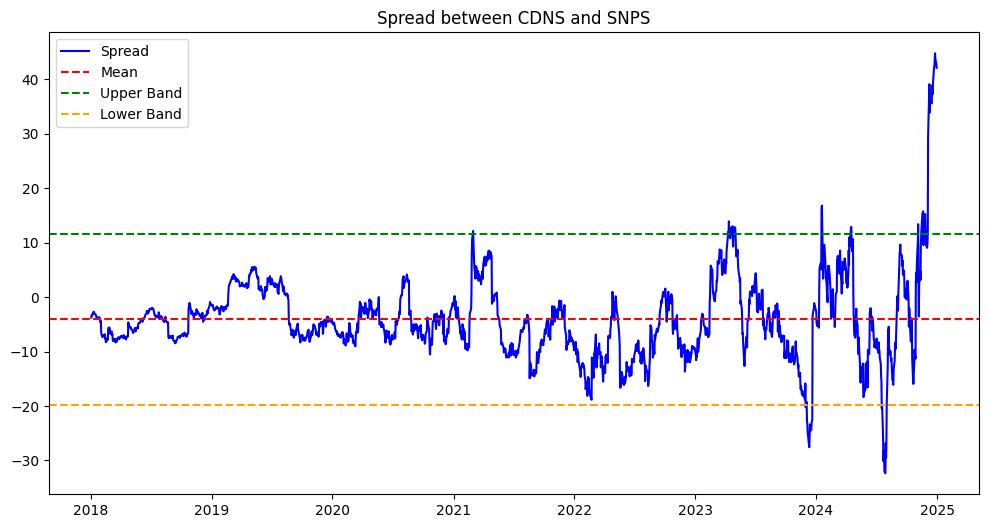

Par: ('AMAT', 'LRCX'), Half-life: 71.08, Correlation: 0.99, Z-score vol: 1.00


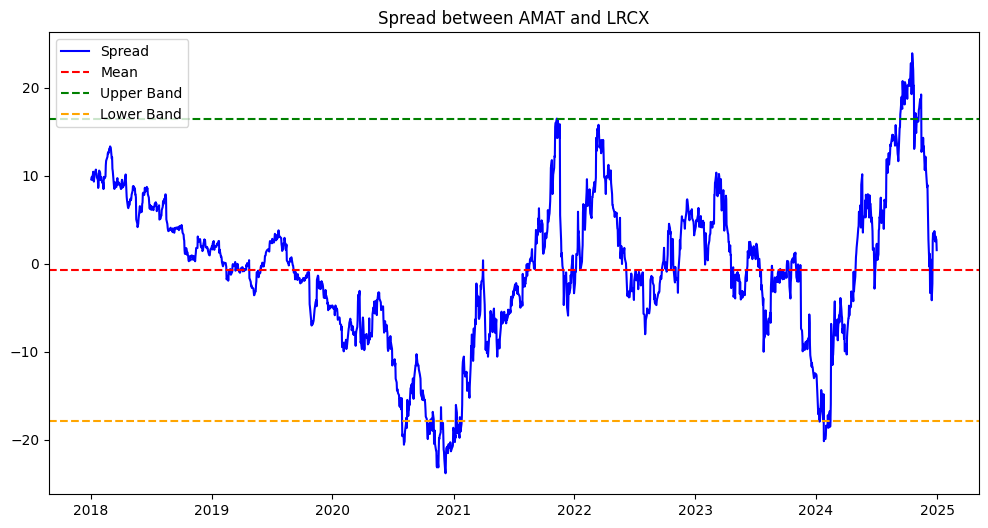

Par: ('ASML', 'LRCX'), Half-life: 68.69, Correlation: 0.97, Z-score vol: 1.00


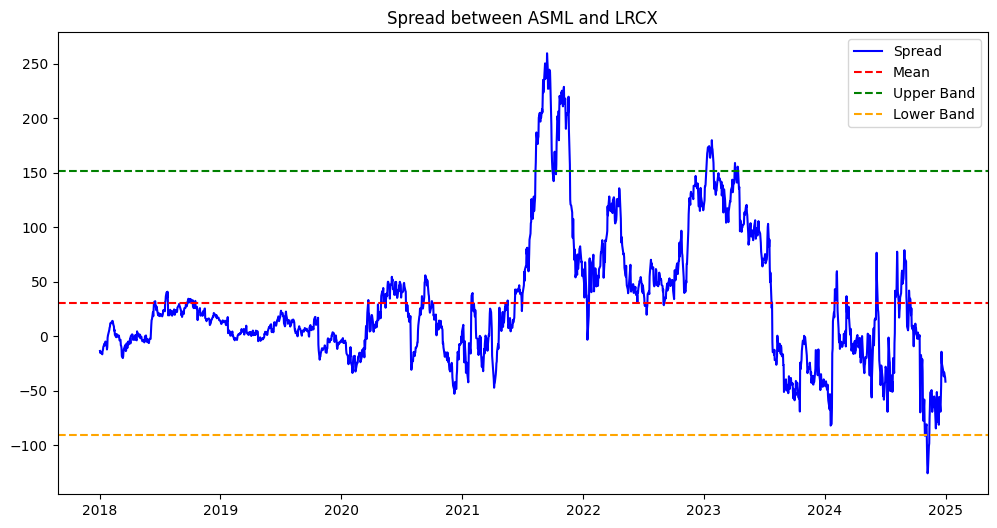

Par: ('AMAT', 'ASML'), Half-life: 83.82, Correlation: 0.97, Z-score vol: 1.00


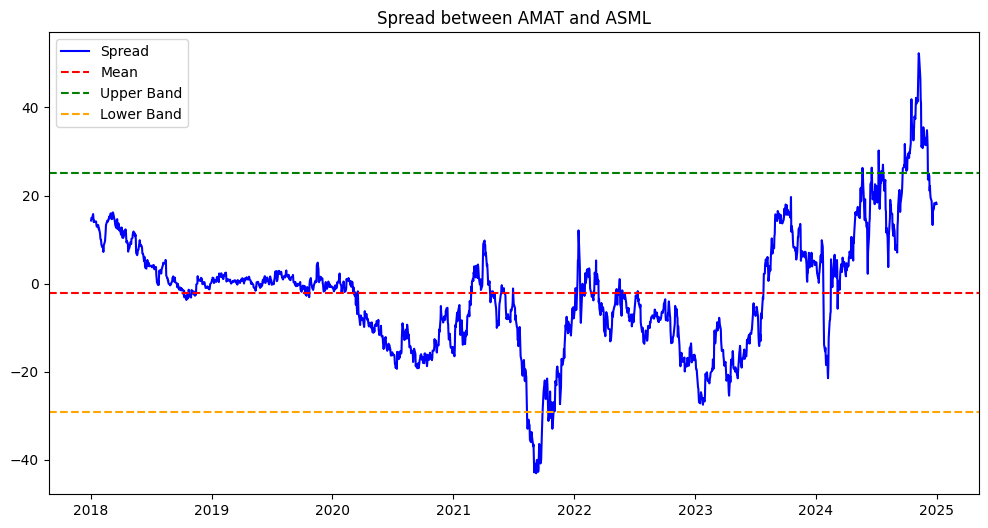

Par: ('AMAT', 'MU'), Half-life: 52.20, Correlation: 0.93, Z-score vol: 1.00


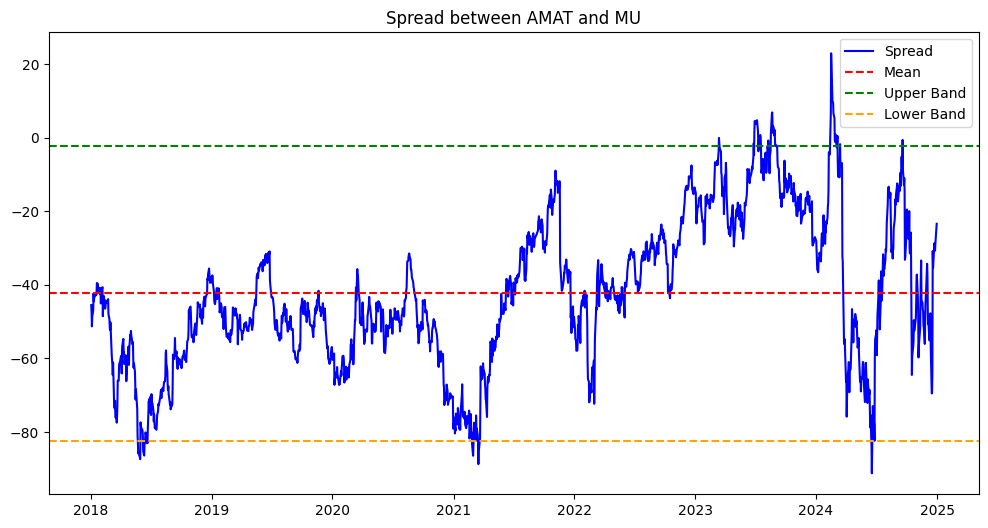

Par: ('ASML', 'MU'), Half-life: 82.91, Correlation: 0.87, Z-score vol: 1.00


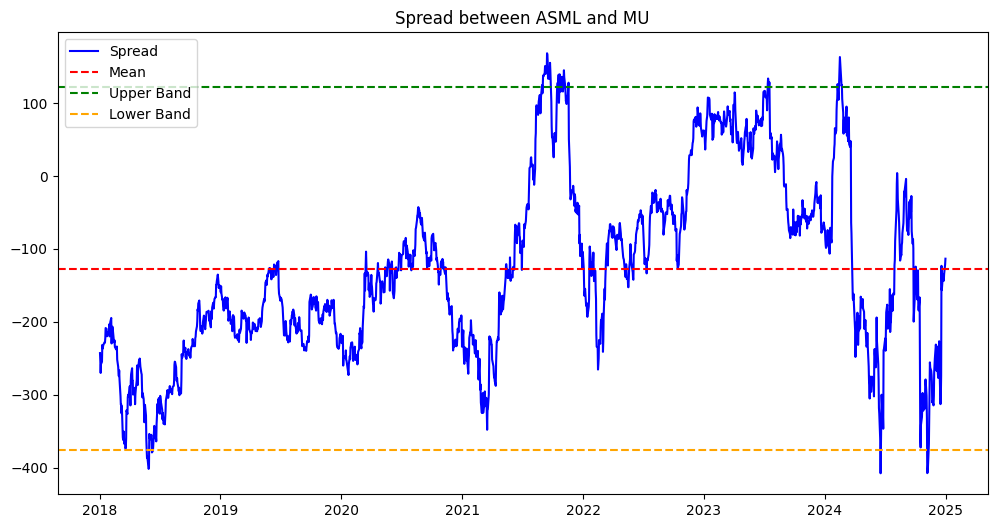

Par: ('EA', 'TTWO'), Half-life: 79.61, Correlation: 0.70, Z-score vol: 1.00


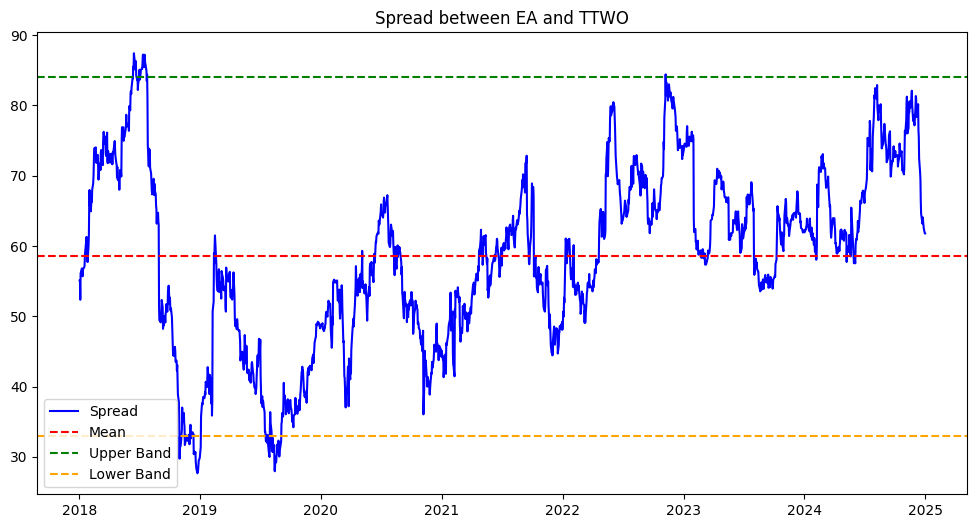

In [31]:
selected_pairs = [pair for pair, _ in top_pairs[:10]]
final_results = []      # para o ranking
pair_stats    = {}      # dicionário com tudo p/ reutilizar (plots etc.)

for pair in selected_pairs:
    j_test  = johansen_test(pair, data)
    eg_test = engle_granger_test(pair, data)
    metrics = calculate_metrics(pair, data)

    pair_stats[pair] = {
        'johansen'      : j_test,
        'engle_granger' : eg_test,
        **metrics       # half_life, correlation, zscore_vol
    }

    # Só pontua se passou em pelo menos um teste
    if j_test or eg_test:
        score = (
        1.0 * int(j_test or eg_test) +
        0.3 * metrics['correlation'] +
        0.3 * (1 / (metrics['half_life'] + 1e-6)) +
        0.1 * (1 / (metrics['zscore_vol'] + 1e-6))
    )

        pair_stats[pair]['score'] = score
        final_results.append({'pair': pair, **pair_stats[pair]})

results_df = (
    pd.DataFrame(final_results)
      .sort_values('score', ascending=False)
)

if results_df.empty:
    print("Nenhum par passou nos testes de cointegração.")
else:
    print("\nTop pares cointegrados encontrados:")
    display(
        results_df[['pair', 'johansen', 'engle_granger',
                    'half_life', 'correlation', 'zscore_vol', 'score']].head(10)
    )

print("\nResultados detalhados e spread:")
for pair in results_df['pair']:                 # já vem ordenado por score
    stats = pair_stats[pair]
    print(
        f"Par: {pair}, "
        f"Half-life: {stats['half_life']:.2f}, "
        f"Correlation: {stats['correlation']:.2f}, "
        f"Z-score vol: {stats['zscore_vol']:.2f}"
    )
    plot_spread(pair, data)



Top pares persistentes ao longo do tempo:
('AMAT', 'LRCX'): apareceu em 6325 janelas
('KLAC', 'LRCX'): apareceu em 5979 janelas
('AMAT', 'KLAC'): apareceu em 5906 janelas
('CDNS', 'SNPS'): apareceu em 5667 janelas
('QRVO', 'SWKS'): apareceu em 5566 janelas
('ADI', 'TXN'): apareceu em 5301 janelas
('ADI', 'MCHP'): apareceu em 5281 janelas
('MCHP', 'TXN'): apareceu em 5040 janelas
('KO', 'PEP'): apareceu em 4884 janelas
('MCHP', 'NXPI'): apareceu em 4858 janelas
Par não cointegrado: AMAT - LRCX (Trace statistic: 12.5674, Critical value 5%: 15.4943)
AVISO: Par cointegrado (p_value < 0.1): AMAT - LRCX (ADF statistic: -2.5691, p-value: 0.0996)
Par não cointegrado: KLAC - LRCX (Trace statistic: 5.7141, Critical value 5%: 15.4943)
Par não cointegrado: KLAC - LRCX (ADF statistic: -2.0827, p-value: 0.2515)
Par não cointegrado: AMAT - KLAC (Trace statistic: 7.2145, Critical value 5%: 15.4943)
Par não cointegrado: AMAT - KLAC (ADF statistic: -2.3930, p-value: 0.1437)
Par cointegrado: CDNS - SNPS

,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



Resultados detalhados e spread:
Par: ('CDNS', 'SNPS'), Half-life: 42.44, Correlation: 1.00, Z-score vol: 1.00


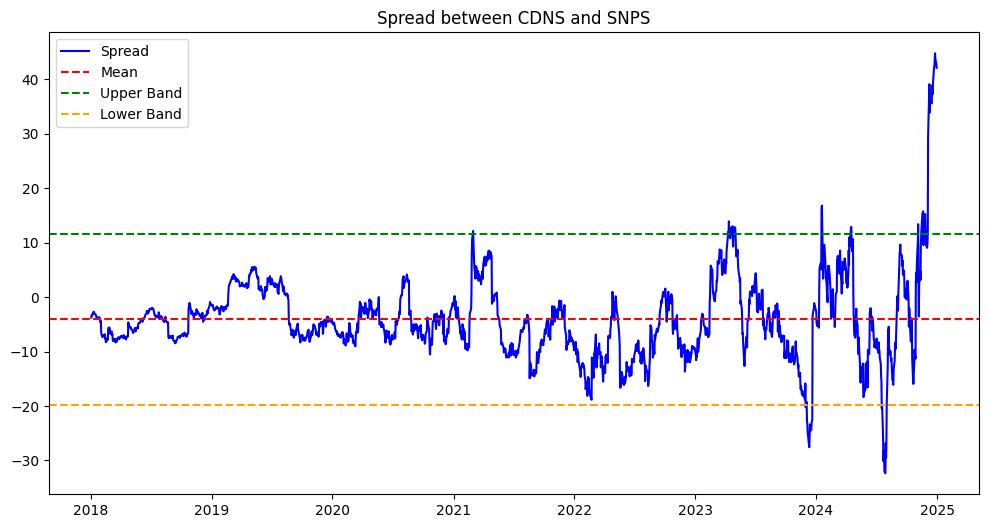

Par: ('QRVO', 'SWKS'), Half-life: 31.53, Correlation: 0.97, Z-score vol: 1.00


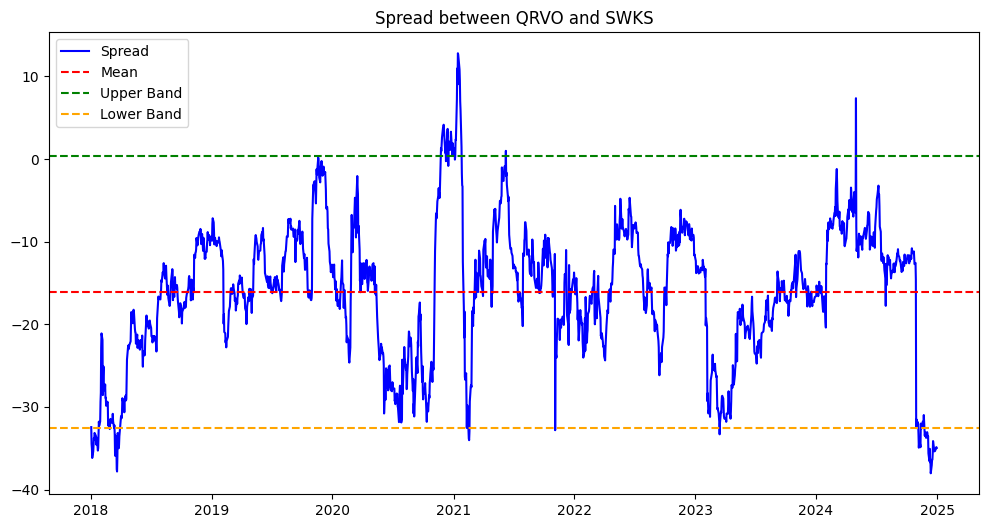

Par: ('AMAT', 'LRCX'), Half-life: 71.08, Correlation: 0.99, Z-score vol: 1.00


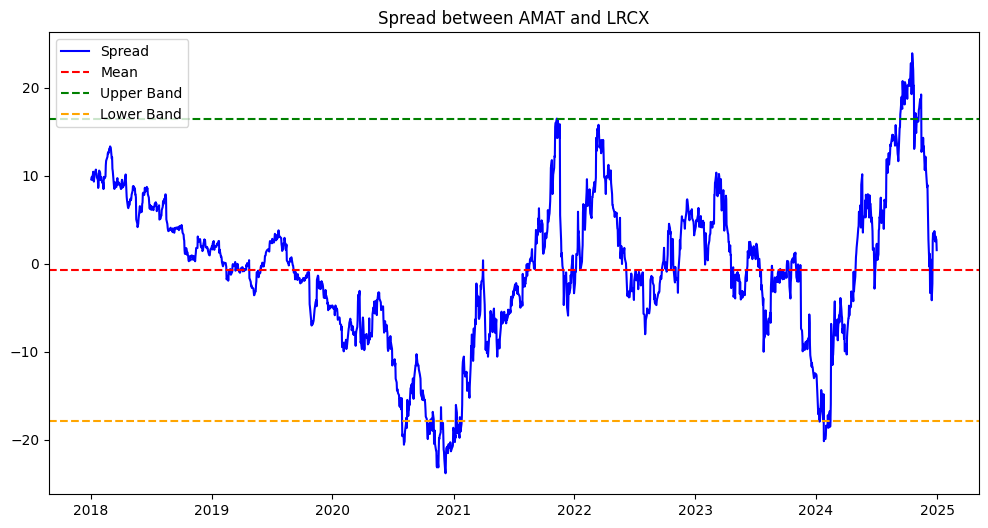

Par: ('MCHP', 'NXPI'), Half-life: 77.69, Correlation: 0.95, Z-score vol: 1.00


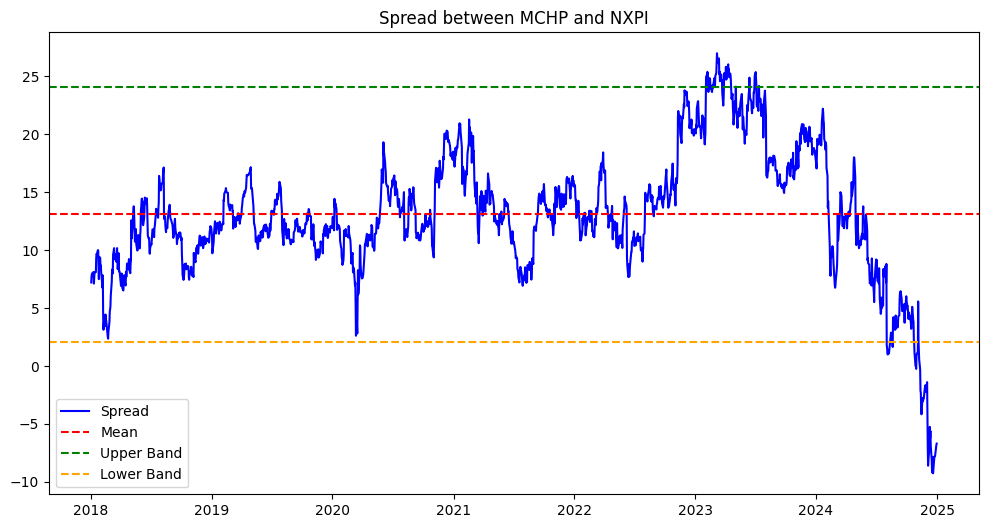

Par: ('ADI', 'TXN'), Half-life: 96.50, Correlation: 0.95, Z-score vol: 1.00


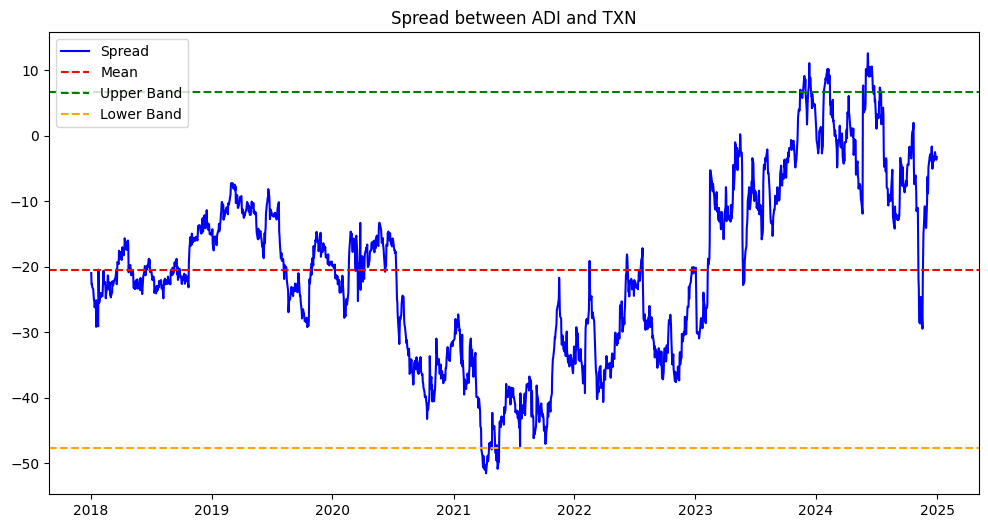

In [32]:

# Definições
window_sizes = [30, 60, 90, 120, 150, 180]
step_sizes = [10, 20, 30]
thresholds = [0.5, 1.0, 1.5, 2.0]
rolling_pairs_all = defaultdict(list)

# Loop principal sobre todas as janelas e parâmetros
for window in window_sizes:
    for step in step_sizes:
        for threshold in thresholds:
            for start in range(0, len(data) - window, step):
                end = start + window
                window_data = data.iloc[start:end]
                returns = window_data.pct_change(fill_method=None).dropna()

                if returns.shape[0] < 10:
                    continue
                if np.abs(returns).max().max() > 0.5:
                    continue

                corr_matrix = returns.corr()
                distance_matrix = np.sqrt(2 * (1 - corr_matrix))
                linked = linkage(squareform(distance_matrix), method='ward')
                clusters = fcluster(linked, threshold, criterion='distance')
                cluster_labels = pd.Series(clusters, index=returns.columns)

                for cluster_id in np.unique(clusters):
                    cluster_stocks = cluster_labels[cluster_labels == cluster_id].index.tolist()
                    if len(cluster_stocks) > 1:
                        pairs = [(cluster_stocks[i], cluster_stocks[j])
                                 for i in range(len(cluster_stocks))
                                 for j in range(i + 1, len(cluster_stocks))]
                        for pair in pairs:
                            rolling_pairs_all[pair].append((start, end))

# Selecionar apenas os pares persistentes
seen_all = {pair for pair, windows in rolling_pairs_all.items() if len(windows) > 1}
rolling_pairs_filtered = {pair: rolling_pairs_all[pair] for pair in seen_all}

# Contagem de persistência
pair_counts_all = {pair: len(windows) for pair, windows in rolling_pairs_filtered.items()}
top_pairs_all = sorted(pair_counts_all.items(), key=lambda x: x[1], reverse=True)

print("\nTop pares persistentes ao longo do tempo:")
for pair, count in top_pairs_all[:10]:
    print(f"{pair}: apareceu em {count} janelas")

# Seleção e avaliação dos pares
selected_pairs_all = [pair for pair, _ in top_pairs_all[:10]]
final_results_all = []
pair_stats_all = {}

for pair in selected_pairs_all:
    j_test = johansen_test(pair, data)
    eg_test = engle_granger_test(pair, data)
    metrics = calculate_metrics(pair, data)

    pair_stats_all[pair] = {
        'johansen': j_test,
        'engle_granger': eg_test,
        **metrics
    }

    if j_test or eg_test:
        score = (
            1.0 * int(j_test or eg_test) +
            0.3 * metrics['correlation'] +
            0.3 * (1 / (metrics['half_life'] + 1e-6)) +
            0.1 * (1 / (metrics['zscore_vol'] + 1e-6))
        )

        pair_stats_all[pair]['score'] = score
        final_results_all.append({'pair': pair, **pair_stats_all[pair]})

results_df_all = pd.DataFrame(final_results_all).sort_values('score', ascending=False)

if results_df_all.empty:
    print("\nNenhum par passou nos testes de cointegração.")
else:
    print("\nTop pares cointegrados encontrados:")
    display(results_df_all[['pair', 'johansen', 'engle_granger', 'half_life', 'correlation', 'zscore_vol', 'score']].head(10))

    print("\nResultados detalhados e spread:")
    for pair in results_df_all['pair']:
        stats = pair_stats_all[pair]
        print(
            f"Par: {pair}, "
            f"Half-life: {stats['half_life']:.2f}, "
            f"Correlation: {stats['correlation']:.2f}, "
            f"Z-score vol: {stats['zscore_vol']:.2f}"
        )
        plot_spread(pair, data)


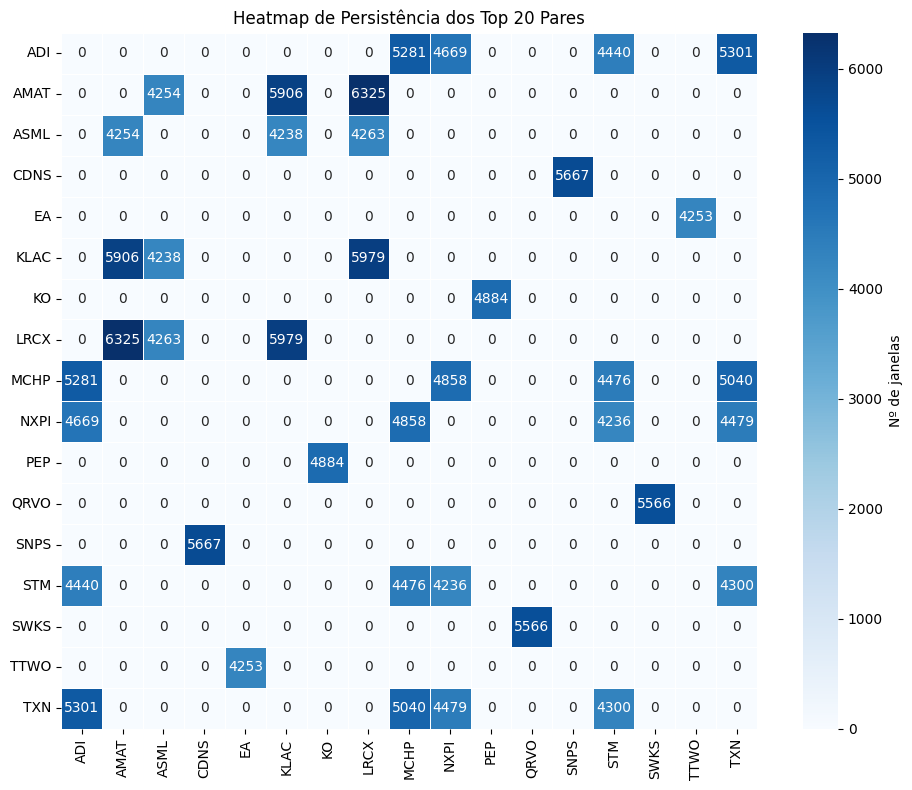

In [33]:
# Obter os top 20 pares com mais janelas
top_pairs_20 = sorted(pair_counts_all.items(), key=lambda x: x[1], reverse=True)[:20]

# Obter os nomes únicos dos ativos nos top pares
top_assets = sorted(set([s for pair, _ in top_pairs_20 for s in pair]))

# Inicializar matriz
persist_matrix_top = pd.DataFrame(0, index=top_assets, columns=top_assets)

# Preencher a matriz só com os top pares
for (s1, s2), count in top_pairs_20:
    persist_matrix_top.loc[s1, s2] = count
    persist_matrix_top.loc[s2, s1] = count  # manter simétrico

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(persist_matrix_top, cmap='Blues', annot=True, fmt='d', square=True, linewidths=0.5, cbar_kws={'label': 'Nº de janelas'})
plt.title("Heatmap de Persistência dos Top 20 Pares")
plt.tight_layout()
plt.show()

In [34]:

# Definições para o loop de rolling
window_sizes = [30, 60, 90, 120, 150, 180]
step_sizes = [10, 20, 30]
thresholds = [0.5, 1.0, 1.5, 2.0]

# Guardar resumo dos resultados
summary_stats = []

for window in window_sizes:
    for step in step_sizes:
        for threshold in thresholds:
            rolling_pairs = defaultdict(list)

            for start in range(0, len(data) - window, step):
                end = start + window
                window_data = data.iloc[start:end]
                returns = window_data.pct_change(fill_method=None).dropna()

                if returns.shape[0] < 10 or np.abs(returns).max().max() > 0.5:
                    continue

                corr_matrix = returns.corr()
                distance_matrix = np.sqrt(2 * (1 - corr_matrix))
                linked = linkage(squareform(distance_matrix), method='ward')
                clusters = fcluster(linked, threshold, criterion='distance')
                cluster_labels = pd.Series(clusters, index=returns.columns)

                for cluster_id in np.unique(clusters):
                    cluster_stocks = cluster_labels[cluster_labels == cluster_id].index.tolist()
                    if len(cluster_stocks) > 1:
                        pairs = [(cluster_stocks[i], cluster_stocks[j])
                                 for i in range(len(cluster_stocks))
                                 for j in range(i + 1, len(cluster_stocks))]
                        for pair in pairs:
                            rolling_pairs[pair].append((start, end))

            # Filtrar pares que aparecem mais de uma vez
            seen_pairs = {pair for pair, windows in rolling_pairs.items() if len(windows) > 1}
            filtered_pairs = {pair: rolling_pairs[pair] for pair in seen_pairs}

            if not filtered_pairs:
                continue

            # Ordenar por número de janelas
            pair_counts = {pair: len(windows) for pair, windows in filtered_pairs.items()}
            top_pairs = sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[:10]

            final_results = []
            pair_stats = {}

            for pair, _ in top_pairs:
                j_test = johansen_test(pair, data, prints=False)
                eg_test = engle_granger_test(pair, data, prints=False)
                metrics = calculate_metrics(pair, data)

                pair_stats[pair] = {
                    'johansen': j_test,
                    'engle_granger': eg_test,
                    **metrics
                }

                if j_test or eg_test:
                    score = (
                        1.0 * int(j_test or eg_test) +
                        0.3 * metrics['correlation'] +
                        0.3 * (1 / (metrics['half_life'] + 1e-6)) +
                        0.1 * (1 / (metrics['zscore_vol'] + 1e-6))
                    )
                    pair_stats[pair]['score'] = score
                    final_results.append({'pair': pair, **pair_stats[pair]})

            results_df = pd.DataFrame(final_results).sort_values('score', ascending=False)

            print(f"\n=== Resultados para window={window}, step={step}, threshold={threshold} ===")
            if results_df.empty:
                print("Nenhum par cointegrado encontrado.")
            else:
                display(results_df[['pair', 'johansen', 'engle_granger', 'half_life', 'correlation', 'zscore_vol', 'score']].head(10))

            johansen_pass_count = sum(1 for v in pair_stats.values() if v['johansen'])
            engle_pass_count = sum(1 for v in pair_stats.values() if v['engle_granger'])

            # (Dentro do teu loop final, logo depois de gerar results_df)
            summary_stats.append({
                'window': window,
                'step': step,
                'threshold': threshold,
                'n_pairs': len(results_df),
                'avg_score': results_df['score'].mean() if not results_df.empty else 0,
                'johansen_pass_count': johansen_pass_count,
                'engle_pass_count': engle_pass_count
            })



=== Resultados para window=30, step=10, threshold=0.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=30, step=10, threshold=1.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=30, step=10, threshold=1.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=30, step=10, threshold=2.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
4,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
2,"(ADI, NXPI)",False,True,73.480974,0.955716,0.999716,1.390826
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=30, step=20, threshold=0.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=30, step=20, threshold=1.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=30, step=20, threshold=1.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=30, step=20, threshold=2.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
4,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
2,"(ADI, NXPI)",False,True,73.480974,0.955716,0.999716,1.390826
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=30, step=30, threshold=0.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
5,"(ADI, NXPI)",False,True,73.480974,0.955716,0.999716,1.390826
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=30, step=30, threshold=1.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
2,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
3,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
1,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=30, step=30, threshold=1.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
3,"(ADI, NXPI)",False,True,73.480974,0.955716,0.999716,1.390826
5,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
2,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596
4,"(MCHP, STM)",False,True,83.093904,0.905524,0.999716,1.375296



=== Resultados para window=30, step=30, threshold=2.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
2,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
3,"(ADI, NXPI)",False,True,73.480974,0.955716,0.999716,1.390826
1,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=60, step=10, threshold=0.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=60, step=10, threshold=1.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=60, step=10, threshold=1.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596
4,"(MCHP, STM)",False,True,83.093904,0.905524,0.999716,1.375296



=== Resultados para window=60, step=10, threshold=2.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
3,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
2,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596
4,"(MCHP, STM)",False,True,83.093904,0.905524,0.999716,1.375296



=== Resultados para window=60, step=20, threshold=0.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=60, step=20, threshold=1.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=60, step=20, threshold=1.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
0,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
1,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596
4,"(MCHP, STM)",False,True,83.093904,0.905524,0.999716,1.375296



=== Resultados para window=60, step=20, threshold=2.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
3,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
2,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=60, step=30, threshold=0.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=60, step=30, threshold=1.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=60, step=30, threshold=1.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
0,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
1,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596
4,"(MCHP, STM)",False,True,83.093904,0.905524,0.999716,1.375296



=== Resultados para window=60, step=30, threshold=2.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
3,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
2,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596
5,"(NXPI, TXN)",True,True,70.886290,0.940064,0.999716,1.386280



=== Resultados para window=90, step=10, threshold=0.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=90, step=10, threshold=1.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
2,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
1,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=90, step=10, threshold=1.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
3,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
2,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=90, step=10, threshold=2.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(ASML, LRCX)",False,True,68.693468,0.970290,0.999716,1.395482
3,"(AMAT, ASML)",False,True,83.821152,0.968080,0.999716,1.394031



=== Resultados para window=90, step=20, threshold=0.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=90, step=20, threshold=1.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
2,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
1,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=90, step=20, threshold=1.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
0,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
1,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=90, step=20, threshold=2.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
4,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
3,"(ASML, LRCX)",False,True,68.693468,0.970290,0.999716,1.395482
2,"(AMAT, ASML)",False,True,83.821152,0.968080,0.999716,1.394031



=== Resultados para window=90, step=30, threshold=0.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=90, step=30, threshold=1.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
2,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
1,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=90, step=30, threshold=1.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
4,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
1,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
2,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596
3,"(AMAT, MU)",False,True,52.197057,0.928306,0.999716,1.384267



=== Resultados para window=90, step=30, threshold=2.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
3,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
2,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=120, step=10, threshold=0.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=120, step=10, threshold=1.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
2,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
1,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=120, step=10, threshold=1.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
4,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
1,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596
2,"(MCHP, STM)",False,True,83.093904,0.905524,0.999716,1.375296



=== Resultados para window=120, step=10, threshold=2.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
3,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
2,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=120, step=20, threshold=0.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=120, step=20, threshold=1.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
2,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
1,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=120, step=20, threshold=1.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
3,"(AMAT, ASML)",False,True,83.821152,0.968080,0.999716,1.394031
2,"(MCHP, STM)",False,True,83.093904,0.905524,0.999716,1.375296



=== Resultados para window=120, step=20, threshold=2.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
4,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
2,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596
3,"(EA, TTWO)",False,True,79.614838,0.697300,0.999716,1.312986



=== Resultados para window=120, step=30, threshold=0.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=120, step=30, threshold=1.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
2,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
1,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=120, step=30, threshold=1.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
1,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596
0,"(AMAT, MU)",False,True,52.197057,0.928306,0.999716,1.384267
3,"(LRCX, MU)",False,True,63.685860,0.921141,0.999716,1.381081



=== Resultados para window=120, step=30, threshold=2.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
2,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596
3,"(AMAT, MU)",False,True,52.197057,0.928306,0.999716,1.384267



=== Resultados para window=150, step=10, threshold=0.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=150, step=10, threshold=1.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
3,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
1,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
2,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=150, step=10, threshold=1.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
1,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596
0,"(MCHP, STM)",False,True,83.093904,0.905524,0.999716,1.375296



=== Resultados para window=150, step=10, threshold=2.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
3,"(ASML, LRCX)",False,True,68.693468,0.970290,0.999716,1.395482
2,"(AMAT, ASML)",False,True,83.821152,0.968080,0.999716,1.394031
4,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=150, step=20, threshold=0.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=150, step=20, threshold=1.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
3,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
1,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
2,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=150, step=20, threshold=1.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
1,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596
0,"(MCHP, STM)",False,True,83.093904,0.905524,0.999716,1.375296



=== Resultados para window=150, step=20, threshold=2.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
3,"(ASML, LRCX)",False,True,68.693468,0.970290,0.999716,1.395482
2,"(AMAT, ASML)",False,True,83.821152,0.968080,0.999716,1.394031
4,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=150, step=30, threshold=0.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=150, step=30, threshold=1.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
3,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
1,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
2,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=150, step=30, threshold=1.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
1,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596
0,"(MCHP, STM)",False,True,83.093904,0.905524,0.999716,1.375296



=== Resultados para window=150, step=30, threshold=2.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
2,"(AMAT, ASML)",False,True,83.821152,0.968080,0.999716,1.394031



=== Resultados para window=180, step=10, threshold=0.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=180, step=10, threshold=1.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
2,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
1,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=180, step=10, threshold=1.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
4,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
3,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
0,"(AMAT, MU)",False,True,52.197057,0.928306,0.999716,1.384267
2,"(MCHP, STM)",False,True,83.093904,0.905524,0.999716,1.375296



=== Resultados para window=180, step=10, threshold=2.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
3,"(ASML, LRCX)",False,True,68.693468,0.970290,0.999716,1.395482
2,"(AMAT, ASML)",False,True,83.821152,0.968080,0.999716,1.394031
4,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=180, step=20, threshold=0.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=180, step=20, threshold=1.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=180, step=20, threshold=1.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
4,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
3,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
0,"(AMAT, MU)",False,True,52.197057,0.928306,0.999716,1.384267
2,"(MCHP, STM)",False,True,83.093904,0.905524,0.999716,1.375296



=== Resultados para window=180, step=20, threshold=2.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
3,"(ASML, LRCX)",False,True,68.693468,0.970290,0.999716,1.395482
2,"(AMAT, ASML)",False,True,83.821152,0.968080,0.999716,1.394031
4,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=180, step=30, threshold=0.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=180, step=30, threshold=1.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
2,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
1,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



=== Resultados para window=180, step=30, threshold=1.5 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
3,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
0,"(AMAT, MU)",False,True,52.197057,0.928306,0.999716,1.384267
2,"(MCHP, STM)",False,True,83.093904,0.905524,0.999716,1.375296



=== Resultados para window=180, step=30, threshold=2.0 ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
2,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
1,"(TER, TXN)",False,True,60.114349,0.925918,0.999716,1.382794


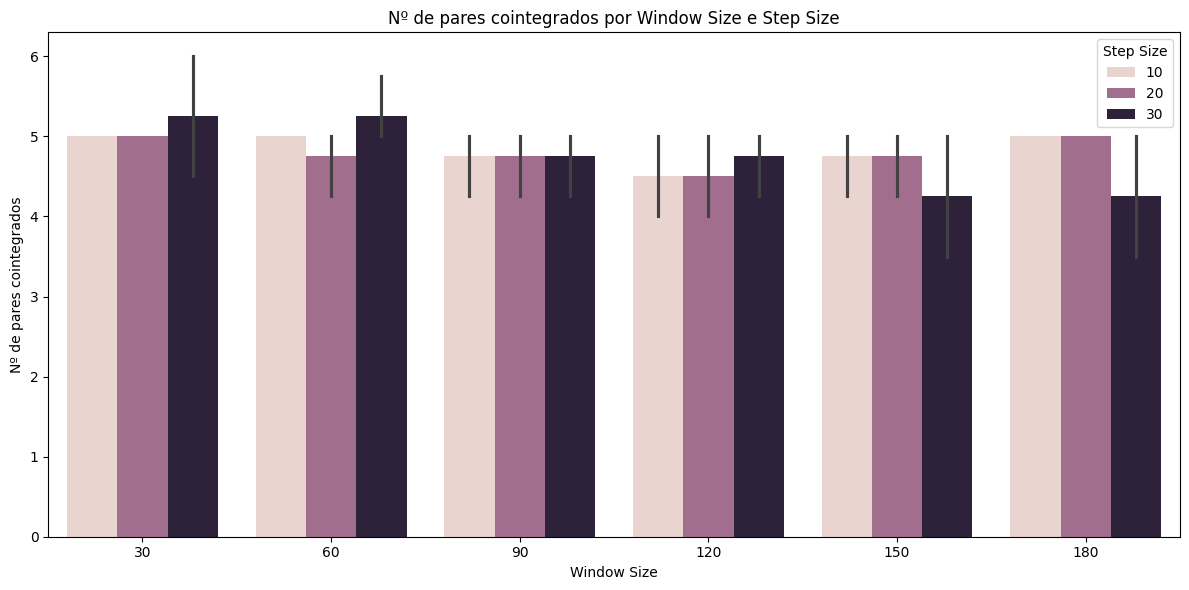

In [35]:
summary_df = pd.DataFrame(summary_stats)

plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df, x='window', y='n_pairs', hue='step')
plt.title("Nº de pares cointegrados por Window Size e Step Size")
plt.ylabel("Nº de pares cointegrados")
plt.xlabel("Window Size")
plt.legend(title="Step Size")
plt.tight_layout()
plt.show()


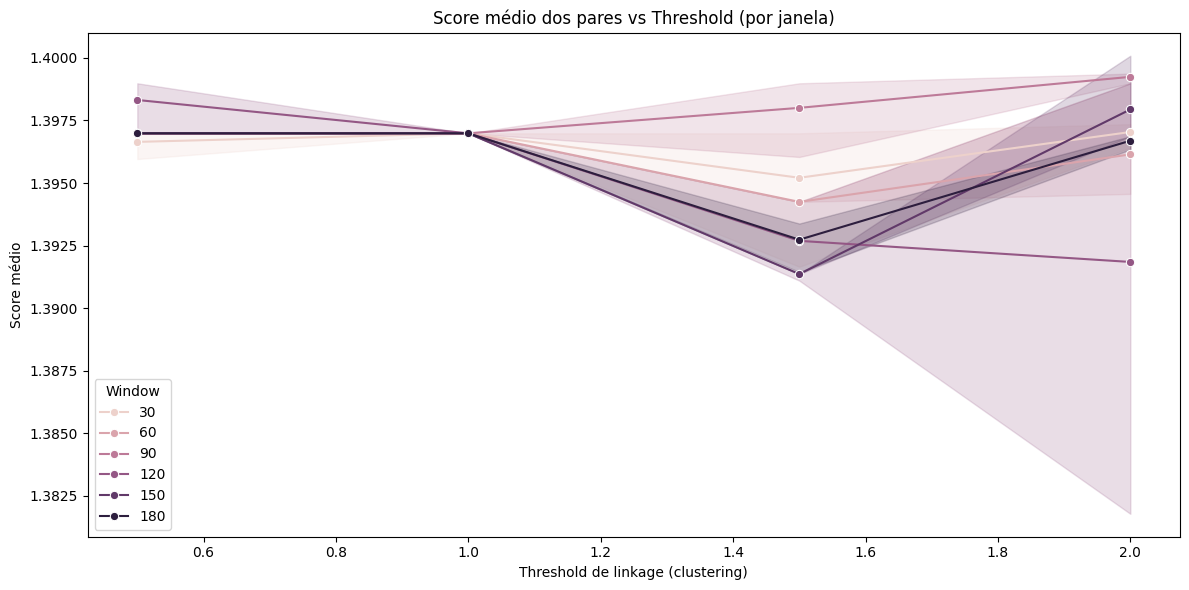

In [36]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=summary_df, x='threshold', y='avg_score', hue='window', marker="o")
plt.title("Score médio dos pares vs Threshold (por janela)")
plt.ylabel("Score médio")
plt.xlabel("Threshold de linkage (clustering)")
plt.legend(title="Window")
plt.tight_layout()
plt.show()


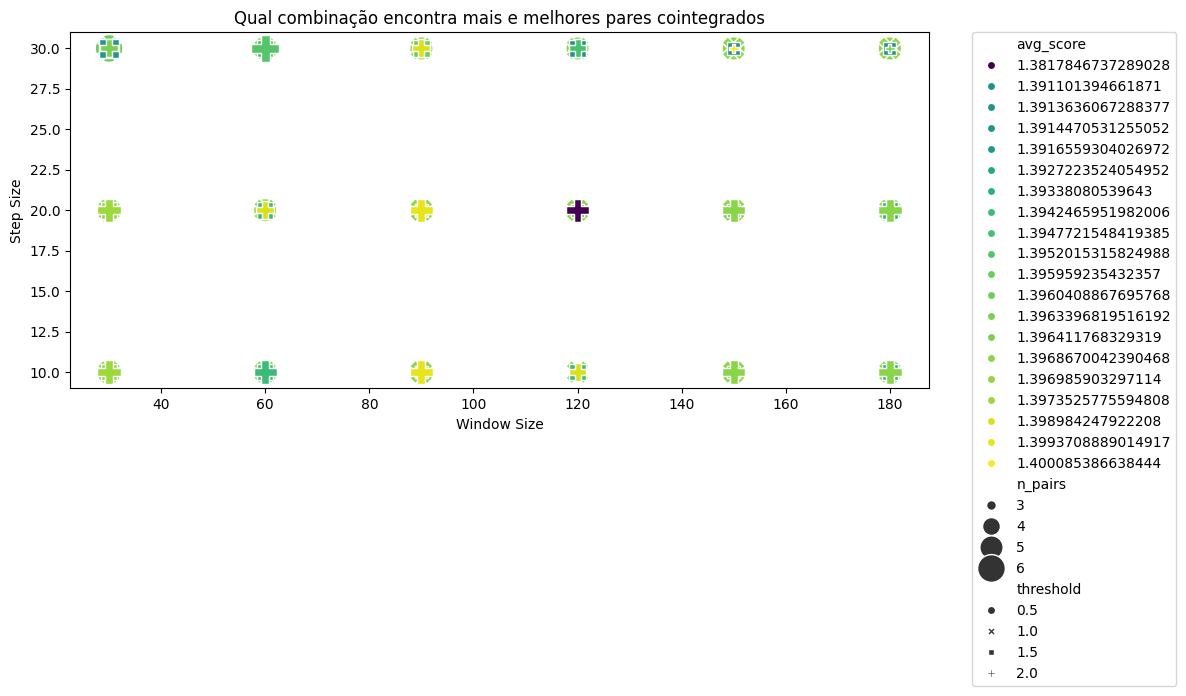

In [37]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=summary_df,
    x='window',
    y='step',
    size='n_pairs',
    hue='avg_score',
    style='threshold',
    palette='viridis',
    sizes=(50, 400),
    legend='full'
)

plt.title("Qual combinação encontra mais e melhores pares cointegrados")
plt.xlabel("Window Size")
plt.ylabel("Step Size")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()


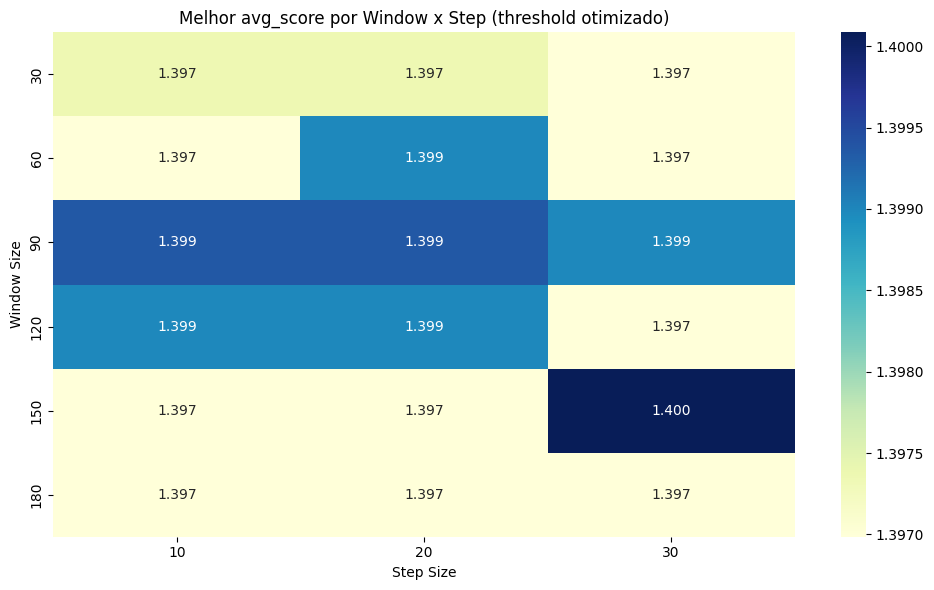

In [38]:
pivot_score = summary_df.groupby(['window', 'step'])['avg_score'].max().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_score, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Melhor avg_score por Window x Step (threshold otimizado)")
plt.xlabel("Step Size")
plt.ylabel("Window Size")
plt.tight_layout()
plt.show()


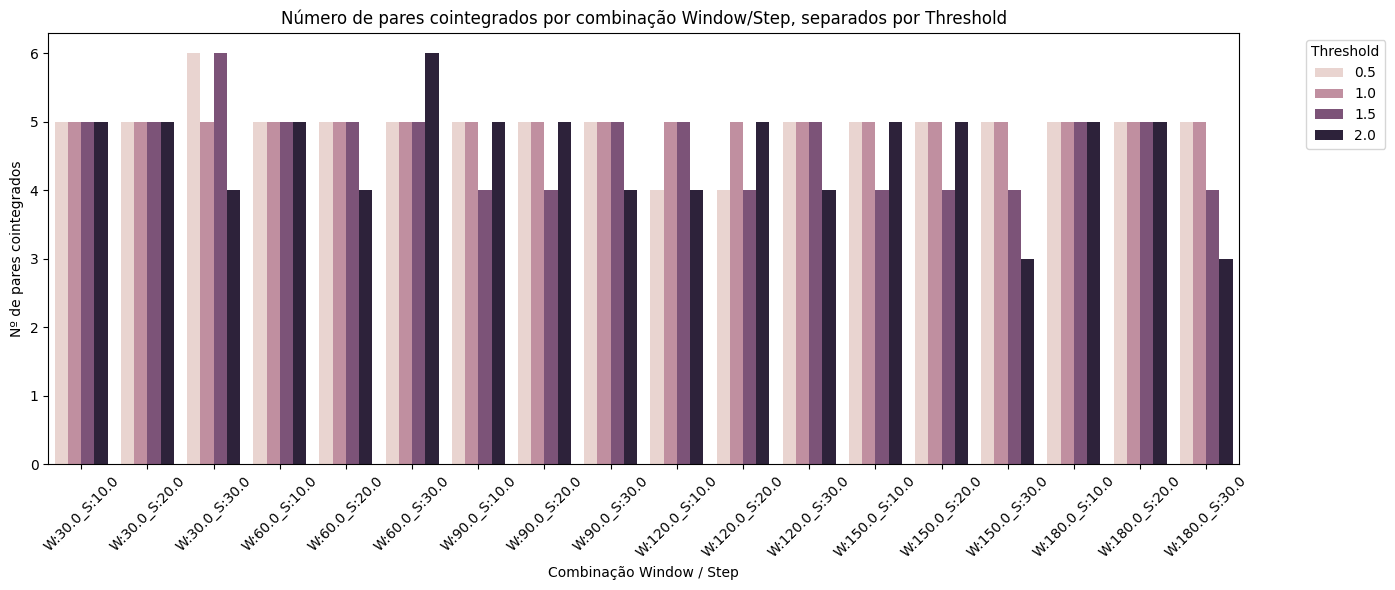

In [39]:
summary_df['label'] = summary_df.apply(lambda row: f"W:{row['window']}_S:{row['step']}", axis=1)

plt.figure(figsize=(14, 6))
sns.barplot(data=summary_df, x='label', y='n_pairs', hue='threshold')
plt.xticks(rotation=45)
plt.title("Número de pares cointegrados por combinação Window/Step, separados por Threshold")
plt.xlabel("Combinação Window / Step")
plt.ylabel("Nº de pares cointegrados")
plt.legend(title='Threshold', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


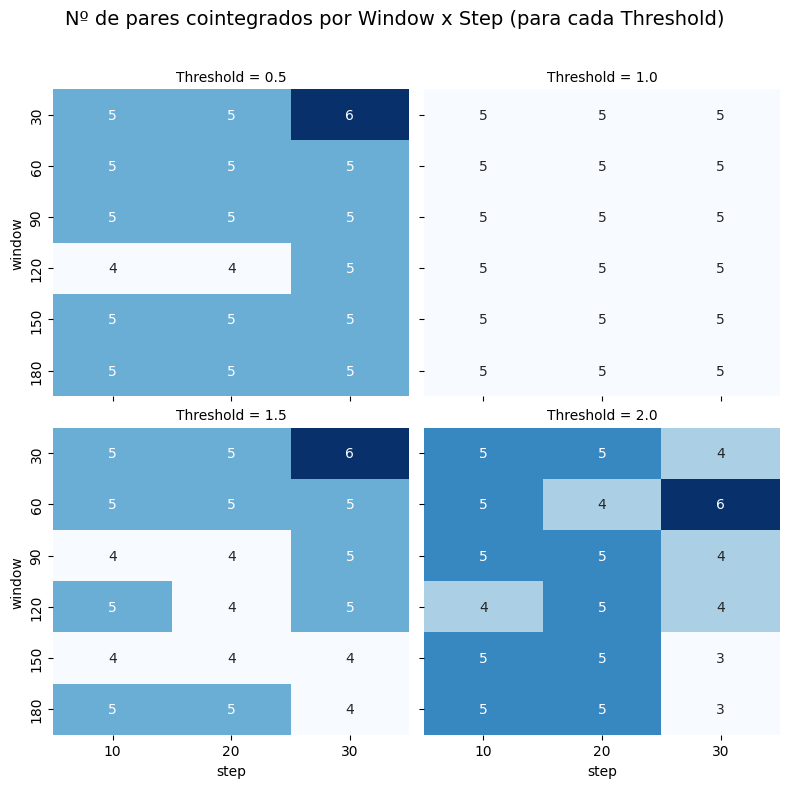

In [40]:
g = sns.FacetGrid(summary_df, col="threshold", col_wrap=2, height=4, sharey=True)

def heatmap_n_pairs(data, **kwargs):
    pivot = data.pivot_table(index="window", columns="step", values="n_pairs", aggfunc='mean')
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="Blues", cbar=False, **kwargs)

g.map_dataframe(heatmap_n_pairs)
g.set_titles("Threshold = {col_name}")
g.fig.suptitle("Nº de pares cointegrados por Window x Step (para cada Threshold)", fontsize=14)
g.fig.subplots_adjust(top=0.88)
plt.show()



=== Melhor combinação de parâmetros ===
Window: 30, Step: 30, Threshold: 0.5
Nº de pares cointegrados: 6
Score médio: 1.3960

=== Resultados para os melhores parâmetros ===


,pair,johansen,engle_granger,half_life,correlation,zscore_vol,score
1,"(CDNS, SNPS)",True,True,42.439847,0.995605,0.999716,1.405779
2,"(QRVO, SWKS)",True,True,31.526586,0.971906,0.999716,1.401116
0,"(AMAT, LRCX)",False,True,71.080601,0.987325,0.999716,1.400446
5,"(ADI, NXPI)",False,True,73.480974,0.955716,0.999716,1.390826
4,"(MCHP, NXPI)",True,False,77.689646,0.950342,0.999716,1.388993
3,"(ADI, TXN)",False,True,96.502449,0.951531,0.999716,1.388596



Resultados detalhados e spread:
Par: ('CDNS', 'SNPS'), Half-life: 42.44, Correlation: 1.00, Z-score vol: 1.00


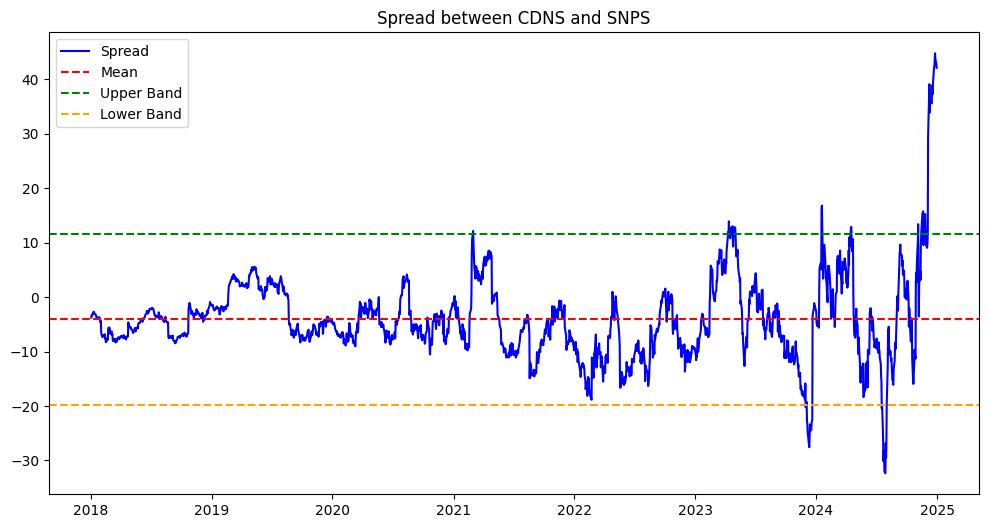

Par: ('QRVO', 'SWKS'), Half-life: 31.53, Correlation: 0.97, Z-score vol: 1.00


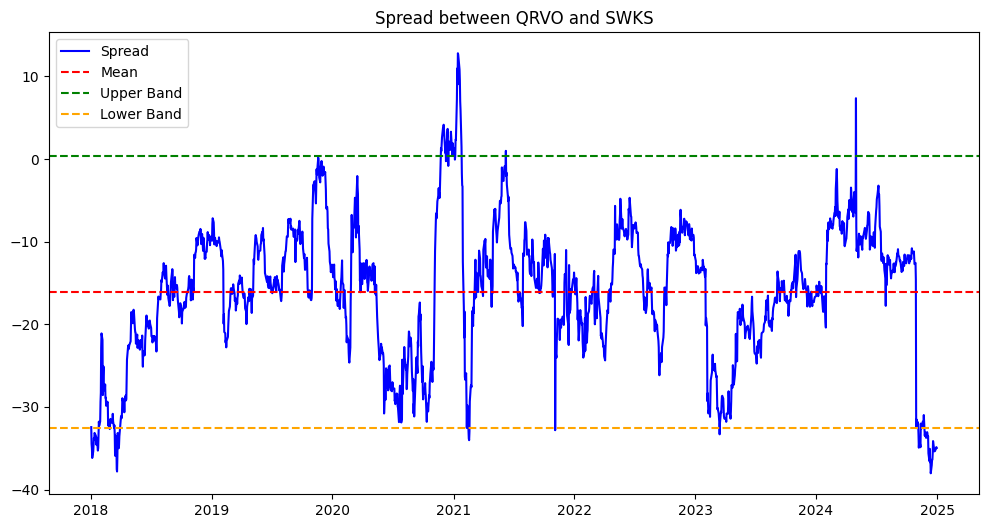

Par: ('AMAT', 'LRCX'), Half-life: 71.08, Correlation: 0.99, Z-score vol: 1.00


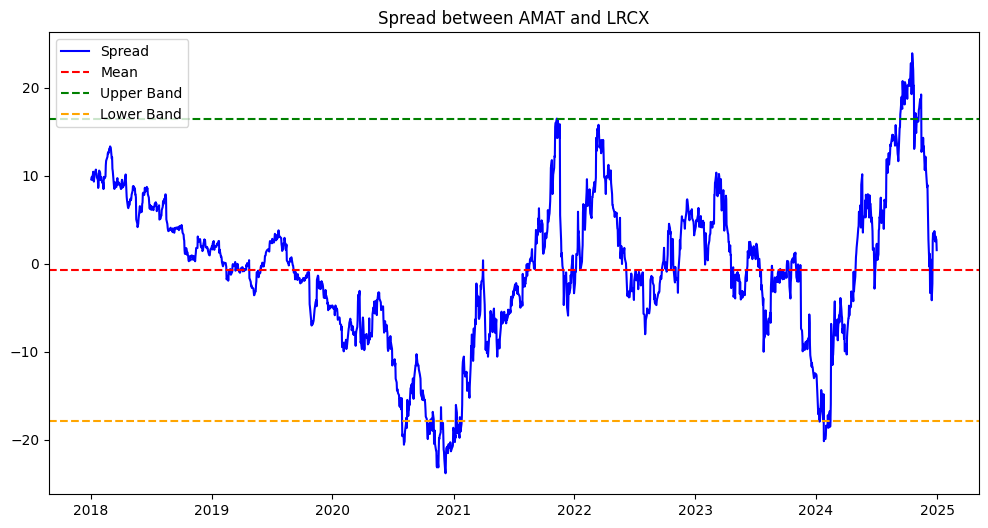

Par: ('ADI', 'NXPI'), Half-life: 73.48, Correlation: 0.96, Z-score vol: 1.00


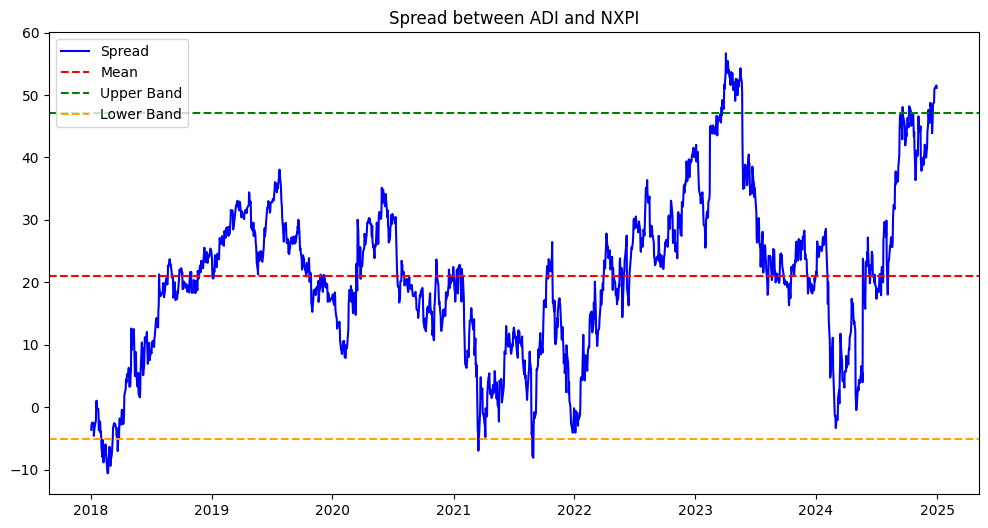

Par: ('MCHP', 'NXPI'), Half-life: 77.69, Correlation: 0.95, Z-score vol: 1.00


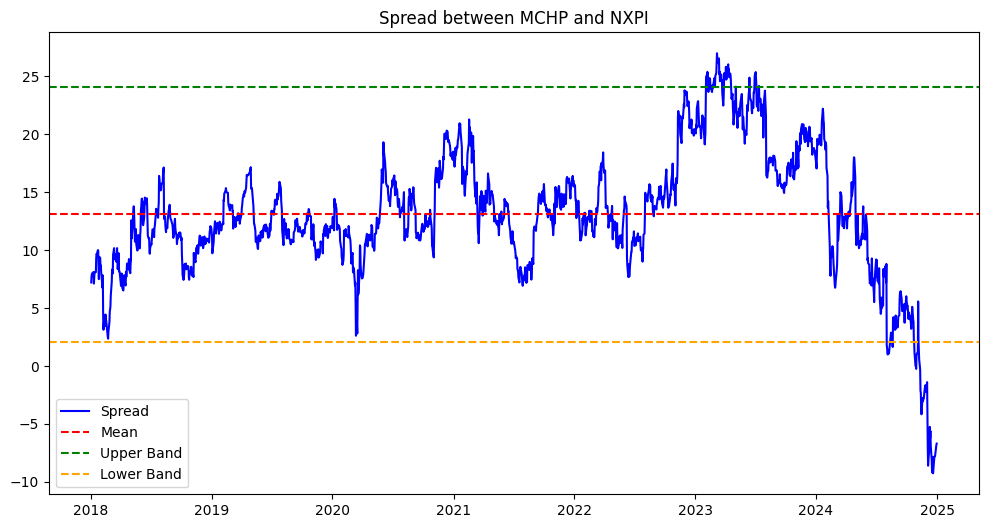

Par: ('ADI', 'TXN'), Half-life: 96.50, Correlation: 0.95, Z-score vol: 1.00


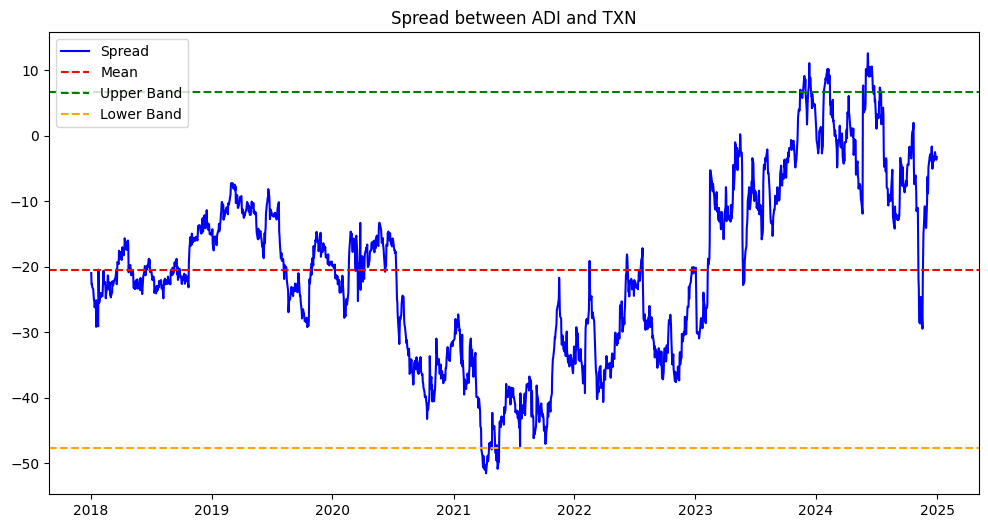

In [41]:
# Escolhe os resultados da combinação de parametros com mais pares cointegrados com o maior score médio
best_summary = max(summary_stats, key=lambda x: (x['n_pairs'], x['avg_score']))
print("\n=== Melhor combinação de parâmetros ===")
print(f"Window: {best_summary['window']}, Step: {best_summary['step']}, Threshold: {best_summary['threshold']}")
print(f"Nº de pares cointegrados: {best_summary['n_pairs']}")
print(f"Score médio: {best_summary['avg_score']:.4f}")

# Display dos pares cointegrados com os melhores parâmetros
best_window = best_summary['window']
best_step = best_summary['step']
best_threshold = best_summary['threshold']
rolling_pairs = defaultdict(list)
for start in range(0, len(data) - best_window, best_step):
    end = start + best_window
    window_data = data.iloc[start:end]
    returns = window_data.pct_change(fill_method=None).dropna()

    if returns.shape[0] < 10 or np.abs(returns).max().max() > 0.5:
        continue

    corr_matrix = returns.corr()
    distance_matrix = np.sqrt(2 * (1 - corr_matrix))
    linked = linkage(squareform(distance_matrix), method='ward')
    clusters = fcluster(linked, best_threshold, criterion='distance')
    cluster_labels = pd.Series(clusters, index=returns.columns)

    for cluster_id in np.unique(clusters):
        cluster_stocks = cluster_labels[cluster_labels == cluster_id].index.tolist()
        if len(cluster_stocks) > 1:
            pairs = [(cluster_stocks[i], cluster_stocks[j])
                     for i in range(len(cluster_stocks))
                     for j in range(i + 1, len(cluster_stocks))]
            for pair in pairs:
                rolling_pairs[pair].append((start, end))
# Filtrar pares que aparecem mais de uma vez
seen_pairs = {pair for pair, windows in rolling_pairs.items() if len(windows) > 1}
filtered_pairs = {pair: rolling_pairs[pair] for pair in seen_pairs}
# Ordenar por número de janelas
pair_counts = {pair: len(windows) for pair, windows in filtered_pairs.items()}
top_pairs = sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[:10]
final_results = []
pair_stats = {}
for pair, _ in top_pairs:
    j_test = johansen_test(pair, data, prints=False)
    eg_test = engle_granger_test(pair, data, prints=False)
    metrics = calculate_metrics(pair, data)

    pair_stats[pair] = {
        'johansen': j_test,
        'engle_granger': eg_test,
        **metrics
    }

    if j_test or eg_test:
        score = (
            1.0 * int(j_test or eg_test) +
            0.3 * metrics['correlation'] +
            0.3 * (1 / (metrics['half_life'] + 1e-6)) +
            0.1 * (1 / (metrics['zscore_vol'] + 1e-6))
        )
        pair_stats[pair]['score'] = score
        final_results.append({'pair': pair, **pair_stats[pair]})
results_df = pd.DataFrame(final_results).sort_values('score', ascending=False)
if results_df.empty:
    print("\nNenhum par cointegrado encontrado.")
else:
    print("\n=== Resultados para os melhores parâmetros ===")
    display(results_df[['pair', 'johansen', 'engle_granger', 'half_life', 'correlation', 'zscore_vol', 'score']].head(10))
    print("\nResultados detalhados e spread:")
    for pair in results_df['pair']:
        stats = pair_stats[pair]
        print(
            f"Par: {pair}, "
            f"Half-life: {stats['half_life']:.2f}, "
            f"Correlation: {stats['correlation']:.2f}, "
            f"Z-score vol: {stats['zscore_vol']:.2f}"
        )
        plot_spread(pair, data)